In [2]:
from sklearn.preprocessing import StandardScaler
#from factor_analyzer import FactorAnalyzer, calculate_kmo
from scipy.stats import bartlett
import pandas as pd
from sklearn.preprocessing import StandardScaler
#from factor_analyzer import FactorAnalyzer, calculate_kmo, calculate_bartlett_sphericity
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import pingouin as pg
import seaborn as sns

In [72]:
# data_path = "data_cleaned_feature_31.parquet"
# data = pd.read_parquet(data_path)
# print(data.columns)
# data.shape

In [73]:
data_path = "data_youtube_cleaned_first_final.csv"
data = pd.read_csv(data_path)
print(data.columns)
data.shape

Index(['video_id', 'video_published_at', 'video_trending__date',
       'video_trending_country', 'channel_id', 'video_title',
       'video_description', 'video_default_thumbnail', 'video_category_id',
       'video_tags', 'video_duration', 'video_dimension', 'video_definition',
       'video_licensed_content', 'video_view_count', 'video_like_count',
       'video_comment_count', 'channel_title', 'channel_description',
       'channel_custom_url', 'channel_published_at', 'channel_country',
       'channel_view_count', 'channel_subscriber_count',
       'channel_have_hidden_subscribers', 'channel_video_count',
       'channel_localized_title', 'channel_localized_description',
       'engagement_rate', 'time_difference', 'video_duration_seconds',
       'time_difference_days', 'channel_cluster',
       'time_to_trend_difference_seconds', 'is_weekend', 'is_trending',
       'published_hour', 'published_morning', 'published_afternoon',
       'published_evening', 'published_night',
      

(28667, 43)

In [74]:
data.is_trending.value_counts() ## checking how fast videos are trending

is_trending
0    14551
1    14116
Name: count, dtype: int64

In [75]:
data['is_weekend'].value_counts()

is_weekend
False    20692
True      7975
Name: count, dtype: int64

In [76]:
# response = requests.get("https://i.ytimg.com/vi/3QBE5eRW1xM/default.jpg", timeout=5)
# image = Image.open(BytesIO(response.content)).convert("RGB")
# results = model(image)  # Perform detection
# print(f"results: {results}")
# print("-------------------------------------------------------------------------------------------------")
# detections_df = results[0].to_df()  # Convert detections to a DataFrame
# print(detections_df)
# print("-------------------------------------------------------------------------------------------------")
# # Check if detections_df is empty
# # if detections_df.empty:
# #     return {'contain_1': None, 'contain_2': None, 'contain_3': None}  # No objects detected

# # Count object occurrences using the 'name' column
# object_counts = detections_df['name'].value_counts()
# print(object_counts)
# # Extract the top 3 detected objects (if available)
# top_objects = object_counts.index.tolist()[:3]
# print(top_objects)
# # Map to new keys for clarity
# result = {
#     'contain_1': top_objects[0] if len(top_objects) > 0 else None,
#     'contain_2': top_objects[1] if len(top_objects) > 1 else None,
#     'contain_3': top_objects[2] if len(top_objects) > 2 else None,
# }
# result

In [77]:
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
from tqdm import tqdm
from ultralytics import YOLO  # Use ultralytics YOLO package or adapt for YOLOv5
import os
from icecream import ic 
from concurrent.futures import ThreadPoolExecutor
import numpy as np
import torch
from torchvision import models, transforms
import logging

model = YOLO('yolo11n.pt')
model.overrides['verbose'] = False  # Disable verbose logging
# logging.getLogger("ultralytics").setLevel(logging.ERROR)
thumbnail_urls = data['video_default_thumbnail']
def detect_objects(image):
    results = model(image)  # Perform detection
    #print(f"results: {results}")
    #print("-------------------------------------------------------------------------------------------------")
    detections_df = results[0].to_df()  # Convert detections to a DataFrame
    #print(detections_df)
    #print("-------------------------------------------------------------------------------------------------")
    # Check if detections_df is empty
    if detections_df.empty:
        return {'contain_1': None, 'contain_2': None, 'contain_3': None}  # No objects detected

    # Count object occurrences using the 'name' column
    # object_counts = detections_df['name'].value_counts()
    # print(object_counts)
    # Extract the top 3 detected objects (if available)
    top_objects = detections_df['name'].values[:3]
    contains_face = int('person' in top_objects)
    
    # Map to new keys for clarity
    result = {
        'contain_1': top_objects[0] if len(top_objects) > 0 else None,
        'contain_2': top_objects[1] if len(top_objects) > 1 else None,
        'contain_3': top_objects[2] if len(top_objects) > 2 else None,
    }
    
    return result

def analyze_colors(image):
    image = image.resize((100, 100))  # Resize for speed
    pixels = np.array(image).reshape(-1, 3)  # Flatten pixels
    dominant_color = np.mean(pixels, axis=0)  # Average color (RGB)
    brightness = np.mean(np.sqrt(np.sum(pixels**2, axis=1)))  # Brightness metric
    color_diversity = len(np.unique(pixels, axis=0))  # Distinct colors
    return {
        'dominant_color_r': dominant_color[0],
        'dominant_color_g': dominant_color[1],
        'dominant_color_b': dominant_color[2],
        'brightness': brightness,
        'color_diversity': color_diversity
    }

In [78]:
results_list = []
for url in tqdm(thumbnail_urls, desc="Processing Thumbnails", unit="image"):
    try:
        # Download image
        response = requests.get(url, timeout=5)
        image = Image.open(BytesIO(response.content)).convert("RGB")

        # Detect objects
        detection_results = detect_objects(image)
        color_analysis = analyze_colors(image)
        combined_results = {**detection_results, **color_analysis, 'thumbnail_url': url}
        results_list.append(combined_results)

    except Exception as e:
        print(f"Failed to process {url}: {e}")
        results_list.append({'thumbnail_url': url, 'error': str(e)})

Processing Thumbnails: 100%|██████████| 28667/28667 [1:20:07<00:00,  5.96image/s]


In [79]:
final_data = pd.merge(data, pd.DataFrame(results_list), how="left", left_on='video_default_thumbnail', right_on='thumbnail_url')

In [3]:
final_data = pd.read_csv("yolo_image_data_12082024.csv")
final_data.shape

(28667, 52)

In [4]:
data = final_data.copy()
data.shape

(28667, 52)

In [5]:
data[['contain_1','contain_2','contain_3']]

,contain_1,contain_2,contain_3
0,person,car,NaN
1,person,person,NaN
2,person,person,NaN
3,person,person,person
4,donut,person,person
...,...,...,...
28662,person,person,NaN
28663,person,person,person
28664,person,person,person
28665,person,person,person


In [6]:
data.contain_1.value_counts()

contain_1
person        22298
cell phone      359
tv              314
car             289
clock           277
              ...  
surfboard         2
snowboard         1
couch             1
knife             1
bear              1
Name: count, Length: 71, dtype: int64

In [7]:
data['tag_count'] = data['video_tags'].apply(lambda x: 0 if x == 'No tags' else len(x.split(',')))
data['tag_count'].value_counts()

tag_count
0      7748
6       669
4       663
23      657
14      652
       ... 
105       1
94        1
93        1
131       1
111       1
Name: count, Length: 110, dtype: int64

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


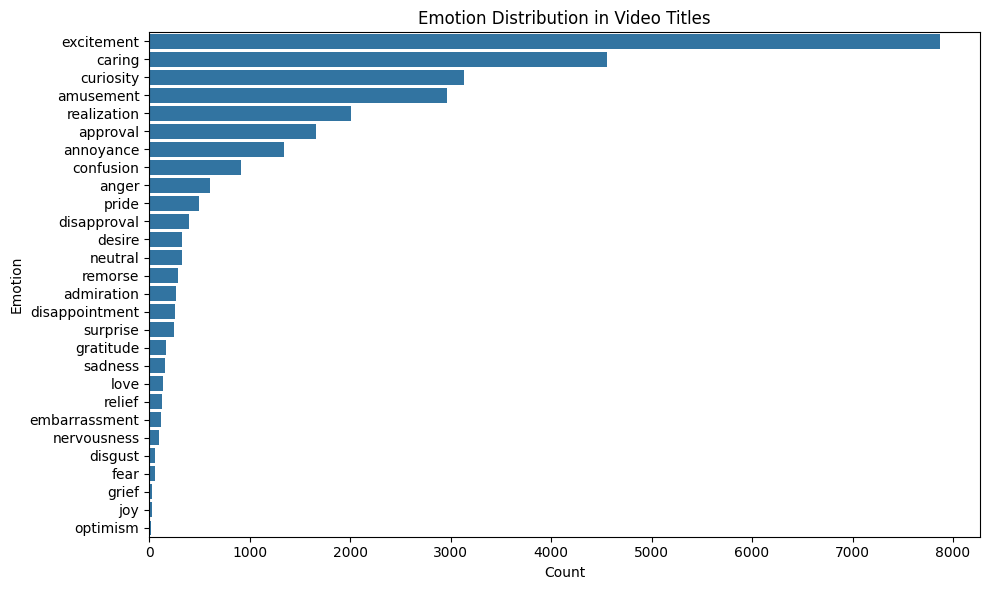

In [8]:
from transformers import pipeline

text_features = ['video_title']

def clean_text_column(column):

    return (
        column.fillna("") 
        .str.replace(r"[^\w\s]", " ", regex=True) 
        .str.lower()  
        .str.strip()  
    )

for text_feature in text_features:
    data[text_feature] = clean_text_column(data[text_feature])
    
    
from transformers import pipeline
import torch
import seaborn as sns
import matplotlib.pyplot as plt

device = 0 if torch.cuda.is_available() else -1

emotion_analyzer = pipeline("text-classification", model="joeddav/distilbert-base-uncased-go-emotions-student", device=device)

data['video_title_emotion'] = data['video_title'].apply(lambda x: emotion_analyzer(x)[0]['label'])

# Plot emotion distribution
plt.figure(figsize=(10, 6))
sns.countplot(y=data['video_title_emotion'], order=data['video_title_emotion'].value_counts().index)
plt.title('Emotion Distribution in Video Titles')
plt.xlabel('Count')
plt.ylabel('Emotion')
plt.tight_layout()
plt.show()

In [11]:
data[['contain_1', 'contain_2',
       'contain_3', 'dominant_color_r', 'dominant_color_g', 'dominant_color_b',
       'brightness', 'color_diversity']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28667 entries, 0 to 28666
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   contain_1         25573 non-null  object 
 1   contain_2         18153 non-null  object 
 2   contain_3         11347 non-null  object 
 3   dominant_color_r  28667 non-null  float64
 4   dominant_color_g  28667 non-null  float64
 5   dominant_color_b  28667 non-null  float64
 6   brightness        28667 non-null  float64
 7   color_diversity   28667 non-null  int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 1.7+ MB


In [12]:
categorical_features = [
    'video_category_id', 'is_weekend',
    'video_definition', 'video_dimension', 'video_licensed_content',
    'channel_country', 'channel_have_hidden_subscribers',
    'published_morning', 'published_afternoon', 'published_evening', 'published_night', 'contain_1', 'contain_2',
       'contain_3','video_title_emotion'
]
numerical_features = [
    'video_duration_seconds', 'channel_video_count', 'channel_video_channel_publish_difference',
    'dominant_color_r', 'dominant_color_g', 'dominant_color_b',
       'brightness', 'color_diversity','tag_count'
]

In [13]:
X_categorical = data[categorical_features]
X_numerical = data[numerical_features]
#X_text = data[embedded_text_columns]?
y = data['is_trending']

In [14]:
# from sklearn.ensemble import IsolationForest
# isolation_forest = IsolationForest(contamination=0.10, random_state=42) 
# outliers = isolation_forest.fit_predict(X_numerical)

# data_cleaned = data[outliers != -1]
# data_cleaned.shape

In [32]:
import numpy as np
#X = np.hstack((X_numerical, X_categorical))
X = pd.concat((X_numerical, X_categorical),axis=1)
X.shape

(28667, 24)

In [16]:
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, DropCorrelatedFeatures
from feature_engine.pipeline import Pipeline
from feature_engine.imputation import CategoricalImputer
from feature_engine.encoding import RareLabelEncoder
pipeline = Pipeline([
    ("categorical_imputer", CategoricalImputer(
    variables=['contain_1', 'contain_2', 'contain_3'],
    fill_value="Empty")),
    ("rare_label_encode", RareLabelEncoder(tol=0.005, ignore_format=False)),
    ("num_rare_label_encode", RareLabelEncoder(tol=0.005, ignore_format=True, variables=['tag_count'], replace_with=-1)),
    ("drop_constant_features", DropConstantFeatures(tol=0.90)),
    ("drop_duplicate_features", DropDuplicateFeatures()),
    ("drop_correlated_features", DropCorrelatedFeatures(method='pearson', threshold=0.90))
])

X_final = pipeline.fit_transform(X)
X_final.shape

/usr/local/lib/python3.11/dist-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable video_definition is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable video_dimension is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(


(28667, 20)

In [17]:
# check difference of columns between X and X_final
set(X.columns) - set(X_final.columns)

{'channel_have_hidden_subscribers',
 'video_definition',
 'video_dimension',
 'video_licensed_content'}

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.3, random_state=42)

In [21]:
categorical_features = [
    'video_category_id', 'is_weekend',
    
    'channel_country', 
    'published_morning', 'published_afternoon', 'published_evening', 'published_night', 'contain_1', 'contain_2', 'contain_3',
       'video_title_emotion'
]
numerical_features = [
    'video_duration_seconds', 'channel_video_count', 'channel_video_channel_publish_difference',
    'dominant_color_r', 'dominant_color_b', 'dominant_color_g',
       'brightness', 'color_diversity','tag_count'
]

In [24]:
X_train_categorical = X_train[categorical_features]
X_test_categorical = X_test[categorical_features]

X_train_numerical = X_train[numerical_features]
X_test_numerical = X_test[numerical_features]

In [25]:
from feature_engine.encoding import DecisionTreeEncoder
from feature_engine.encoding import OneHotEncoder
from feature_engine.encoding import MeanEncoder

encoder = MeanEncoder()
X_train_encode = encoder.fit_transform(X_train_categorical, y_train)
X_test_encode = encoder.transform(X_test_categorical)

In [26]:
# from feature_engine.transformation import LogTransformer

# log_transformer = LogTransformer(variables=numerical_features)

# X_train_log = log_transformer.fit_transform(X_train_numerical)
# X_test_log = log_transformer.transform(X_test_numerical) # di naman gumana hahahaha

In [27]:
# from imblearn.combine import SMOTEENN
# smote_enn = SMOTEENN(random_state=42)
# X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train_combined, X_test_combined)

Model Accuracy: 0.7044529705848157
[[3150 1239]
 [1303 2909]]
              precision    recall  f1-score   support

           0       0.71      0.72      0.71      4389
           1       0.70      0.69      0.70      4212

    accuracy                           0.70      8601
   macro avg       0.70      0.70      0.70      8601
weighted avg       0.70      0.70      0.70      8601



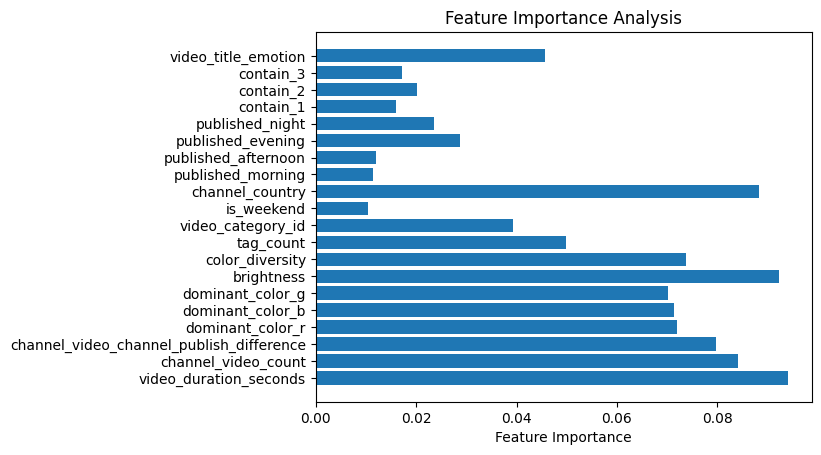

In [28]:
from sklearn.preprocessing import MinMaxScaler
mmx_scaler = MinMaxScaler()
X_train_mmx = mmx_scaler.fit_transform(np.hstack((X_train_numerical, X_train_encode)))
X_test_mmx = mmx_scaler.transform(np.hstack((X_test_numerical, X_test_encode)))

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(max_depth=300,
        max_features='sqrt',
        n_estimators=1000,
        min_samples_leaf=1,
        min_samples_split=3,
        random_state=33)
model.fit(X_train_mmx, y_train)
accuracy = model.score(X_test_mmx, y_test)
print(f"Model Accuracy: {accuracy}")
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(X_test_mmx)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

import matplotlib.pyplot as plt
feature_importances = model.feature_importances_
feature_names = list(X_train_numerical.columns) + list(X_train_categorical.columns)
plt.barh(feature_names, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance Analysis')
plt.show()

Model Accuracy: 0.7053830949889548
[[3154 1235]
 [1299 2913]]
              precision    recall  f1-score   support

           0       0.71      0.72      0.71      4389
           1       0.70      0.69      0.70      4212

    accuracy                           0.71      8601
   macro avg       0.71      0.71      0.71      8601
weighted avg       0.71      0.71      0.71      8601



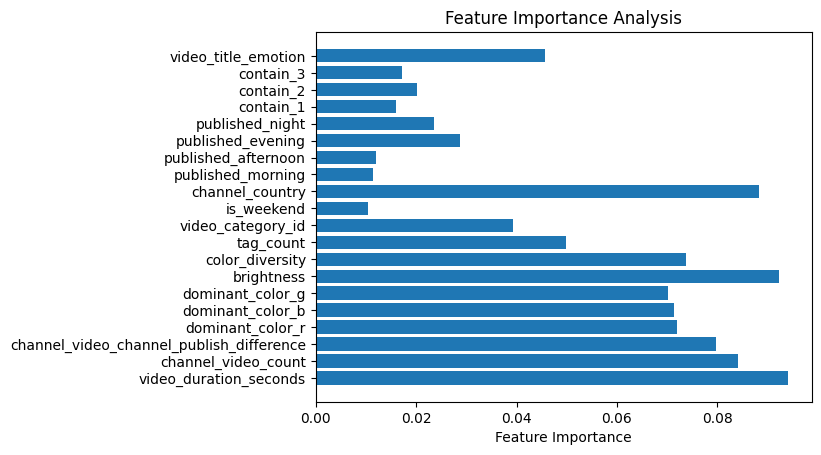

In [29]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
mmx_scaler = StandardScaler()
X_train_mmx = mmx_scaler.fit_transform(np.hstack((X_train_numerical, X_train_encode)))
X_test_mmx = mmx_scaler.transform(np.hstack((X_test_numerical, X_test_encode)))

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(max_depth=300,
        max_features='sqrt',
        n_estimators=1000,
        min_samples_leaf=1,
        min_samples_split=3,
        random_state=33)
model.fit(X_train_mmx, y_train)
accuracy = model.score(X_test_mmx, y_test)
print(f"Model Accuracy: {accuracy}")
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(X_test_mmx)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

import matplotlib.pyplot as plt
feature_importances = model.feature_importances_
feature_names = list(X_train_numerical.columns) + list(X_train_categorical.columns)
plt.barh(feature_names, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance Analysis')
plt.show()

Model Accuracy: 0.7053830949889548
[[3154 1235]
 [1299 2913]]
              precision    recall  f1-score   support

           0       0.71      0.72      0.71      4389
           1       0.70      0.69      0.70      4212

    accuracy                           0.71      8601
   macro avg       0.71      0.71      0.71      8601
weighted avg       0.71      0.71      0.71      8601



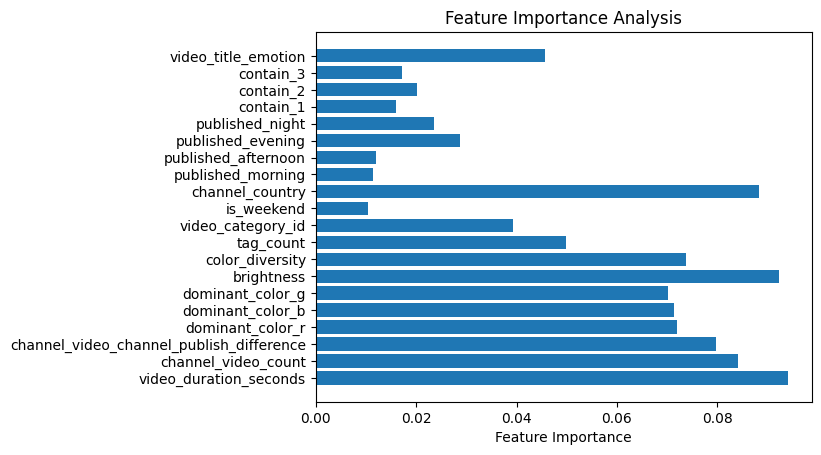

In [30]:
from sklearn.preprocessing import MinMaxScaler
mmx_scaler = StandardScaler()
X_train_mmx = np.hstack((X_train_numerical, X_train_encode))
X_test_mmx = np.hstack((X_test_numerical, X_test_encode))

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(max_depth=300,
        max_features='sqrt',
        n_estimators=1000,
        min_samples_leaf=1,
        min_samples_split=3,
        random_state=33)
model.fit(X_train_mmx, y_train)
accuracy = model.score(X_test_mmx, y_test)
print(f"Model Accuracy: {accuracy}")
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(X_test_mmx)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

import matplotlib.pyplot as plt
feature_importances = model.feature_importances_
feature_names = list(X_train_numerical.columns) + list(X_train_categorical.columns)
plt.barh(feature_names, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance Analysis')
plt.show()